In [ ]:
import sys
import os
import torch
import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
models_path = Path.cwd().parent
if str(models_path) not in sys.path:
    sys.path.append(str(models_path))
    
from torch.utils.data import DataLoader
import multiprocessing
from torchvision.transforms import ToTensor
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
    
import importlib
import unet.Unet as u
importlib.reload(u)

from dataset.IntersectionDataset import IntersectionDataset
import loss.loss_lib as ll
importlib.reload(ll)

<module 'loss.loss_lib' from '/mnt/c/Users/ianda/OneDrive/AU/msc/intersection-traversal/loss/loss_lib.py'>

In [ ]:
import cv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img = cv2.imread("../unet/satellite.png")
img_t = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float().to(device)
model = u.UNet(n_channels=3, n_classes=1).to(device)
output = model(img_t)
print("Output shape:", output.shape)  # Expected: torch.Size([1, 1, 400, 400])
#u.display_output(output)

## Model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = u.UNet(n_channels=3, n_classes=1).to(device)

## Dataset

In [3]:
dataset_dir = "../../dataset/dataset"
img_transform = ToTensor()
path_transform = ToTensor()
dataset = IntersectionDataset(root_dir=dataset_dir,
                              transform=img_transform,
                              path_transform=path_transform)

In [ ]:
len(dataset)

## Dataloader

In [5]:
num_workers = multiprocessing.cpu_count()
b = 8

# split dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=b, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=b, shuffle=True, num_workers=num_workers)

## Optimizer

In [6]:
optimizer = Adam(model.parameters(), lr=1e-3)

## Scheduler

In [7]:
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=1, eta_min=1e-5)

## Loss

In [8]:
alpha = 0.5
lc = ll.CmapLoss().to(device)
lb = ll.BCELoss()

def total_loss(output, target, alpha = 0.5):
    loss = alpha * lc(output, target) + (1 - alpha) * lb(output, target)
    return loss.to(device)

# Training loop

In [ ]:
n_epochs = 500
alpha = 0.5
epochs = tqdm.tqdm(range(n_epochs))

In [9]:
lb = torch.nn.BCEWithLogitsLoss()

In [37]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
for epoch in epochs:
    model.train()
    for batch in train_dataloader:
        satellite = batch["satellite"].to(device)
        path_line = batch["path_line"].to(device)
        cold_map = batch["cold_map"].to(device)
        cmap_f = torch.flatten(cold_map)
        output = model(satellite)
        L_cmap = lc(cmap_f, output)
        L_bce = lb(output, path_line)
        loss = alpha * L_cmap + (1 - alpha) * L_bce
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        


In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
u.display_output(output, threshold=0.5, thresholded=False)

In [ ]:
print(output[0].shape, output.max(), output.min())

torch.Size([3, 400, 400])
torch.Size([3, 400, 400])
torch.Size([3, 400, 400])
torch.Size([3, 400, 400])
torch.Size([3, 400, 400])
torch.Size([3, 400, 400])


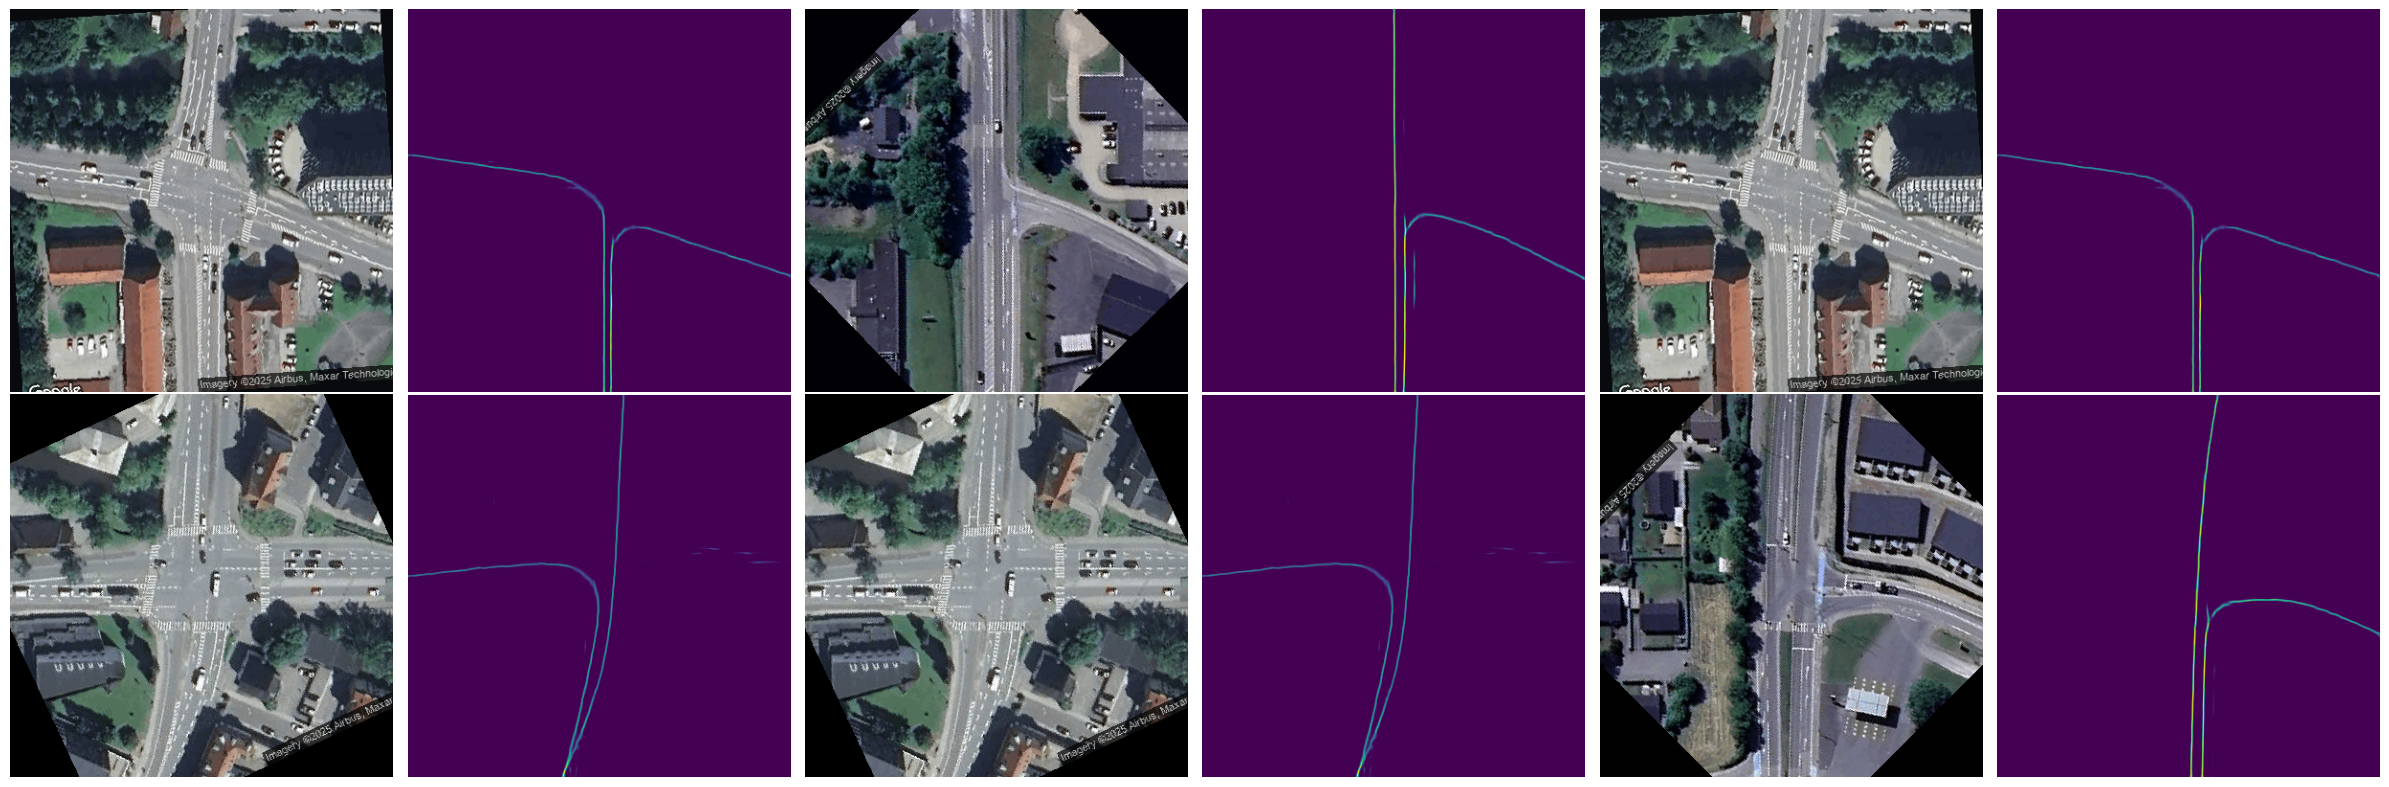

In [54]:
import matplotlib.pyplot as plt
import random

#model.load_state_dict(torch.load("model.pth"))
model.eval()

rows, cols = 2, 6
fig = plt.figure(figsize=(24, 8))
i = 1
while i <= rows * cols:
    r = random.randint(0, len(dataset))
    sat = dataset[r]["satellite"].permute(1, 2, 0)
    fig.add_subplot(rows, cols, i)
    plt.imshow(sat)
    plt.axis("off")
    
    i += 1
    
    fig.add_subplot(rows, cols, i)
    
    s = dataset[r]["satellite"].to(device)
    print(s.shape)
    s = s.unsqueeze(0)
    output = model(s)
    output = torch.sigmoid(output)
    
    output = output.squeeze(0).squeeze(0).detach().cpu().numpy()
    
    plt.imshow(output)
    plt.axis("off")
    
    i += 1
    
fig.tight_layout()


## Add statistics collection

In [10]:
del(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = u.UNet(n_channels=3, n_classes=1).to(device)

del(optimizer)
optimizer = Adam(model.parameters(), lr=1e-3)

del(scheduler)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=1, eta_min=1e-5)

In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

n_epochs = 2000
alpha = 0.5
epochs = tqdm.tqdm(range(n_epochs))

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

for epoch in epochs:
    model.train()
    running_train_loss = 0.0
    running_train_correct = 0
    running_train_total = 0
    
    for batch in train_dataloader:
        satellite = batch["satellite"].to(device)
        path_line = batch["path_line"].to(device)
        cold_map = batch["cold_map"].to(device)
        cmap_f = torch.flatten(cold_map)
        output = model(satellite)
        L_cmap = lc(cmap_f, output)
        L_bce = lb(output, path_line)
        loss = alpha * L_cmap + (1 - alpha) * L_bce
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        
        p = torch.sigmoid(output)
        p = (p > 0.5).float()
        running_train_correct += (p == path_line).sum().item()
        running_train_total += path_line.numel()
        
    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracy = running_train_correct / running_train_total
    train_accuracies.append(train_accuracy)
    
    model.eval()
    running_test_loss = 0.0
    running_test_correct = 0
    running_test_total = 0
    with torch.no_grad():
        for batch in test_dataloader:
            satellite = batch["satellite"].to(device)
            path_line = batch["path_line"].to(device)
            cold_map = batch["cold_map"].to(device)
            cmap_f = torch.flatten(cold_map)
            output = model(satellite)
            L_cmap = lc(cmap_f, output)
            L_bce = lb(output, path_line)
            loss = alpha * L_cmap + (1 - alpha) * L_bce
            
            running_test_loss += loss.item()
            
            p = torch.sigmoid(output)
            p = (p > 0.5).float()
            running_test_correct += (p == path_line).sum().item()
            running_test_total += path_line.numel()
            
    avg_test_loss = running_test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)
    
    test_accuracy = running_test_correct / running_test_total
    test_accuracies.append(test_accuracy)
    
    scheduler.step()
    
    if (epoch + 1) % 100 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_accuracies': train_accuracies,
            'test_accuracies': test_accuracies,
        }
        os.makedirs('./ckpt', exist_ok=True)
        torch.save(checkpoint, f'./ckpt/checkpoint_epoch_{epoch + 1}.pth')
    
    
    #print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")
    
torch.save(model.state_dict(), "model_2000e.pth")
            

  0%|          | 0/2000 [00:00<?, ?it/s]

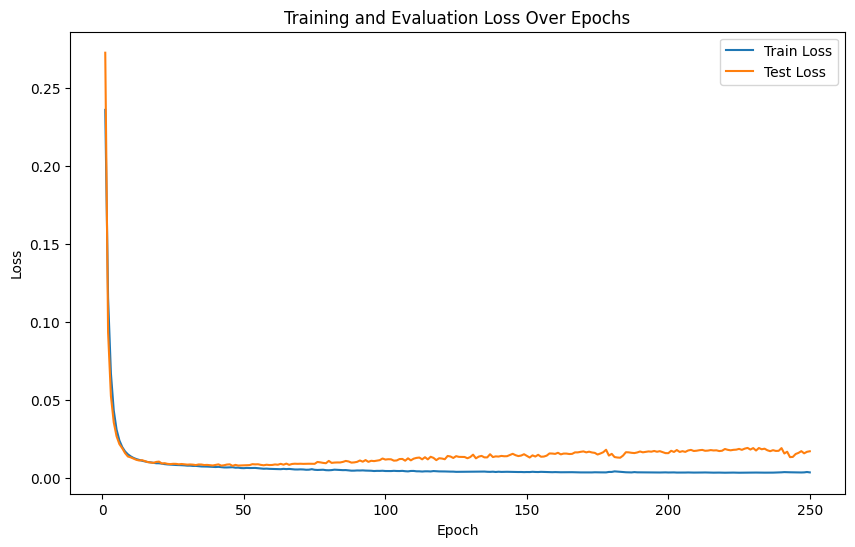

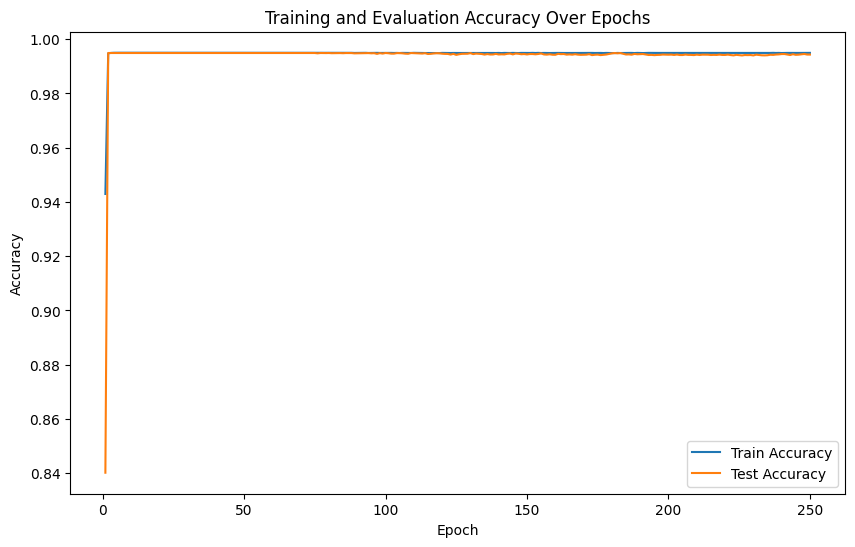

In [52]:
# Plotting the loss graphs
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, n_epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss Over Epochs")
plt.legend()
plt.show()

# Plotting the accuracy graphs
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, n_epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Evaluation Accuracy Over Epochs")
plt.legend()
plt.show()